# BC Dataton

In [1]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns



# Pre-processing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder

#modeling

from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, r2_score

# Feature engineerin and Dimension reduction
from sklearn.feature_selection import VarianceThreshold


# Utils
#from tqdm import tqdm
#from pandas_profiling import ProfileReport
#from pycaret.regression import *


%matplotlib inline

sns.set_style("white")
matplotlib.rc('xtick', labelsize=15)
matplotlib.rc('ytick', labelsize=15)
plt.rcParams['figure.figsize'] = [16.0, 10.0]

In [3]:
data = pd.read_csv("../data/train_201910.csv")
data.head()

g:\mi unidad\packen\data analysis\python\p_projects\bc-dataton\venv\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (3,29,30,32,42,58) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,a,b,c,d,e,f,g,h,i,j,...,ddd,eee,fff,ggg,hhh,iii,jjj,kkk,lll,mmm
0,201910,2089776,19840630,35.236140,M,DIVORCIADO,TECNOLOGO,TECNOLOGIA SISTEMAS,Empleado,ALQUILADA,...,0,0,0,629869,C,0,\N,1255032,\N,95511.00
1,201910,2088434,19880109,31.709788,F,UNION LIBRE,UNIVERSITARIO,VETERINARIA,Comerciante,NO INFORMA,...,0,\N,\N,4742261.859999999,SIN INFO,\N,\N,\N,\N,1929721.00
2,201910,2088089,19860727,33.163587,M,UNION LIBRE,NO INFORMA,\N,Independiente,FAMILIAR,...,0,\N,\N,1698047.975,SIN INFO,\N,\N,\N,\N,374940.00
3,201910,4780572,19940208,25.626283,M,SOLTERO,NO INFORMA,OTROS,Empleado,\N,...,0,5,0,2185655,B,0,\N,\N,\N,2165030.00
4,201910,3894402,19910809,28.128679,M,SOLTERO,TECNOLOGO,DISEÑO Y PUBLICIDAD,Independiente,\N,...,0,2,0,-42000,SIN INFO,0,\N,\N,\N,77469.29


# Data Processing class

In [2]:
class DataFrameBuilder:
    
    HEADER="https://bc-dataton2020.s3.amazonaws.com/dataton_all_data/header.txt"
    NUMERIC_COLUMNS=[
        "edad",
        "ingreso_segurida_social",
        "mora_max",
        "ingreso_nomina",
        "ind",
        "ingreso_final",
        "cuota_cred_hipot",
        "saldo_prom3_tdc_mdo"
    ]
    DROP_COLUMNS=[
        "fecha_nacimiento",
        "profesion",
        "ocupacion",
        "codigo_ciiu",
        "ciudad_residencia",
        "ciudad_laboral",
        "departamento_laboral",
        "nivel_academico",
        "tipo_vivienda",
        "categoria",
        "rechazo_credito",
        "cartera_castigada",
        "cant_moras_30_ult_12_meses",
        "cant_moras_60_ult_12_meses",
        "cant_moras_90_ult_12_meses",
        "ctas_embargadas",
        "tiene_ctas_embargadas",
        "pension_fopep",
        "tiene_cred_hipo_1",
        "tiene_cred_hipo_2",
        "cant_cast_ult_12m_sr",
        "tenencia_tc",
        "tiene_consumo",
        "tiene_crediagil",
        "pol_centr_ext",
        "tiene_ctas_activas"
    ]
    
    def __init__(self, dataframe,date=None, keep_original=False, test=False):
        self.date=date
        self.test=test
        self.original_dataframe = self._assign_columns(dataframe.copy())
        if self.test:
            self.original_dataframe = self._test_preprocess(self.original_dataframe)
            self.dataset_type='test'
        self.cleaned_dataframe = None
        self.keep_original = keep_original
        self.dataset_type='train'

        
    def _assign_columns(self, dataframe):
        column_names = pd.read_csv(DataFrameBuilder.HEADER).columns.to_list()
        if self.test:
            column_names.remove("gasto_familiar")
            column_names.insert(0, "id_registro")
        dataframe.columns = column_names
        return dataframe
    
    def _test_preprocess(self, dataframe):
        dataframe['cant_oblig_tot_sf']=dataframe['cant_oblig_tot_sf'].astype(float).fillna(0).astype(int)
        return dataframe
    
    # Manejo de datos faltantes
    # Reemplazar \N por NA
    def cleanNA(self, dataframe):
        
        for column in dataframe.columns:
            if column in DataFrameBuilder.NUMERIC_COLUMNS :
                dataframe[column] = dataframe[column].replace("\\N", np.nan).astype('float')
        return dataframe
    
    # Modificacion de columnas existentes
    def process_columns(self, dataframe):
        
        # Procesamiento columnas demograficas
        dataframe['edad'] =  dataframe['edad'].round().fillna(method='ffill').astype('int') 
        dataframe['departamento_residencia'] = dataframe['departamento_residencia'].str.strip()
        dataframe['estado_civil'] = np.where(
                    dataframe['estado_civil'] == "SOLTERO", "SOL",
                    np.where(
                        dataframe['estado_civil'] == "CASADO", "CAS",
                        np.where(
                            dataframe['estado_civil'] == "UNION LIBRE", "UL",
                                np.where(
                                    dataframe['estado_civil'] == "NO INFORMA", "NI",
                                        np.where(
                                            dataframe['estado_civil'] == "DIVORCIADO", "DIV",
                                            np.where(
                                                dataframe['estado_civil'] == "VIUDO", "VIU",
                                                    np.where(
                                                        dataframe['estado_civil'] == "\\N", "NI",
                                                        dataframe['estado_civil']
                                                        )
                                                )
                                            )
                                    )
                            )
                        )
                    )
        ########## Procesamiento columnas financieras
        dataframe['convenio_lib'] = np.where(dataframe['convenio_lib'] == "\\N", "N", "S")
        #dataframe['tiene_consumo'] = np.where(dataframe['tiene_consumo'] == "\\N", "N", "S")
        #dataframe['tenencia_tc'] = np.where(dataframe['tenencia_tc'] == "NO", "N", "S")
        dataframe['cat_ingreso'] = np.where(
                                        dataframe['cat_ingreso'] == "\\N","OTROS",
                                        dataframe['cat_ingreso']
        )
        
        dataframe['cuota_cred_hipot'] = dataframe['cuota_cred_hipot'].fillna(0)
        dataframe['cant_oblig_tot_sf'] = pd.Series(np.where(
                                            dataframe['cant_oblig_tot_sf'] == "\\N", "0",
                                            dataframe['cant_oblig_tot_sf']
        )).astype("int")
        
        dataframe['ingreso_nomina'] = dataframe['ingreso_nomina'].fillna(0)
        dataframe['ingreso_segurida_social'] = dataframe['ingreso_segurida_social'].fillna(0)
        
        dataframe['ctas_activas'] = pd.Series(np.where(dataframe['ctas_activas'] =="\\N", "0",
                                             dataframe['ctas_activas']
                                            )).astype("int")
        dataframe['nro_tot_cuentas'] = pd.Series(np.where(dataframe['nro_tot_cuentas'] =="\\N", "0",
                                             dataframe['nro_tot_cuentas']
                                            )).astype("int")
        
        dataframe['cuota_de_consumo'] = dataframe['cuota_de_consumo'].astype(float)
        dataframe['cuota_rotativos'] = dataframe['cuota_rotativos'].astype(float)
        dataframe['cuota_tarjeta_de_credito'] = dataframe['cuota_tarjeta_de_credito'].astype(float)
        dataframe['cuota_de_sector_solidario'] = dataframe['cuota_de_sector_solidario'].astype(float)
        dataframe['cupo_tc_mdo'] = dataframe['cupo_tc_mdo'].astype(float)
        dataframe['saldo_prom3_tdc_mdo'] = dataframe['saldo_prom3_tdc_mdo'].astype(float)
        dataframe['cuota_tc_mdo'] = dataframe['cuota_tc_mdo'].astype(float)
        dataframe['saldo_no_rot_mdo'] = dataframe['saldo_no_rot_mdo'].astype(float)
        dataframe['cuota_libranza_sf'] = dataframe['cuota_libranza_sf'].astype(float)
        dataframe['cuota_sector_real_comercio'] = dataframe['cuota_sector_real_comercio'].astype(float)
        ########### Procesamiento columnas de riesgo
        dataframe['ind_mora_vigente'] = np.where(
                                        dataframe['ind_mora_vigente'] == '\\N', "NApl",
                                        dataframe['ind_mora_vigente']
        )
        dataframe['rep_calif_cred'] = np.where(
                                        dataframe['rep_calif_cred'] == "SIN INFO","NApl",
                                        dataframe['rep_calif_cred']
        )
        
        dataframe['mora_max'] = np.where(
                                   dataframe['mora_max'] < 30, "Entre 0 y 30 dias",
                                   np.where(
                                       dataframe['mora_max'] < 60, "Entre 31 y 60 dias",
                                       np.where(
                                           dataframe['mora_max'] > 60, "Mas de 60", "NApl")
                                   )
        )
        
        dataframe['cant_mora_30_tdc_ult_3m_sf'] = np.where(
                                                    dataframe['cant_mora_30_tdc_ult_3m_sf'] == "\\N", "NApl",
                                                    np.where(
                                                        dataframe['cant_mora_30_tdc_ult_3m_sf'] == "0",
                                                            "SIN MORA", "CON MORA")
        )
        
        dataframe['cant_mora_30_consum_ult_3m_sf'] = np.where(
                                                    dataframe['cant_mora_30_consum_ult_3m_sf'] == "\\N", "NApl",
                                                    np.where(
                                                        dataframe['cant_mora_30_consum_ult_3m_sf'] == "0",
                                                            "SIN MORA", "CON MORA")
        )

        return dataframe
    
    # Para eliminar las columnas que no vamos a usar
    def remove_columns(self, dataframe):
        return dataframe.drop(DataFrameBuilder.DROP_COLUMNS, axis=1)
    
    # Para creacion de columnas nuevas
    def create_columns(self):
        # CREACION CUENTAS PASIVO Y CUENTAS ACTIVAS CON BANCOLOMBIA
        # POSIBLE: SUMAR LOS CUPOS DE TC
        
        pass
    
    def filter_rows(self, dataframe):
        # BORRAR CUENTAS ACTIVAS > 10
        # BORRAR OBLIGACIONES 10+
        pass
    
    # Guardar Dataframe
    def save_dataframe(self, dataframe, path=None):
        dataframe.to_csv(path)
    
    # En esta funcion va todo el flujo
    def build(self, save=True, to_s3=False):
        
        # Borrar variables
        sliced_dataframe = self.remove_columns(self.original_dataframe)
        # Missing values
        na_cleaned_dataframe = self.cleanNA(sliced_dataframe)
        # Procesamiento de columnas
        cleaned_dataframe = self.process_columns(na_cleaned_dataframe)
        self.cleaned_dataframe = cleaned_dataframe
        
        # Eliminar de memoria el dataframe original
        if not self.keep_original:
            self.original_dataframe = None
        
        # Guardado (En local o S3)
        if save:
            self.save_dataframe(cleaned_dataframe, path=f"{self.dataset_type}_{self.date}_cleaned.csv")
        
        return self.cleaned_dataframe
        

In [63]:
test_df = DataFrameBuilder(data,date='201902')

In [64]:
%time test_df.build()

Wall time: 37 s


,periodo,id_cli,edad,genero,estado_civil,ult_actual,ind_mora_vigente,departamento_residencia,mora_max,cupo_total_tc,...,cuota_tc_mdo,saldo_no_rot_mdo,cuota_libranza_sf,cant_oblig_tot_sf,ind,rep_calif_cred,convenio_lib,ingreso_nomina,ingreso_segurida_social,gasto_familiar
0,201910,2089776,35,M,DIV,20180526,N,VALLE,NApl,0.0,...,0.0,0.0,0.0,0,629869.000,C,N,1255032.0,0.0,95511.00
1,201910,2088434,32,F,UL,20190710,N,HUILA,NApl,0.0,...,0.0,0.0,0.0,0,4742261.860,NApl,N,0.0,0.0,1929721.00
2,201910,2088089,33,M,UL,20190312,N,VALLE,Entre 0 y 30 dias,0.0,...,0.0,0.0,0.0,0,1698047.975,NApl,N,0.0,0.0,374940.00
3,201910,4780572,26,M,SOL,20190719,N,BOGOTA D.C.,Entre 0 y 30 dias,15700000.0,...,0.0,9517000.0,0.0,5,2185655.000,B,N,0.0,0.0,2165030.00
4,201910,3894402,28,M,SOL,20190311,N,BOGOTA D.C.,Entre 0 y 30 dias,0.0,...,0.0,2181000.0,0.0,2,-42000.000,NApl,N,0.0,0.0,77469.29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1118881,201910,2892117,35,M,UL,20190726,N,BOGOTA D.C.,Entre 0 y 30 dias,4200000.0,...,0.0,0.0,0.0,0,2145150.000,A,N,0.0,0.0,488768.00
1118882,201910,4772894,33,F,SOL,20190609,N,CUNDINAMARCA,Entre 0 y 30 dias,0.0,...,0.0,0.0,0.0,0,1021137.300,NApl,N,0.0,0.0,114924.71
1118883,201910,4774849,24,F,DIV,20190410,N,BOGOTA D.C.,Entre 0 y 30 dias,0.0,...,0.0,0.0,0.0,1,788100.000,E,N,0.0,0.0,0.00
1118884,201910,3895049,29,M,UL,20190909,N,ANTIOQUIA,Entre 0 y 30 dias,0.0,...,0.0,68000.0,0.0,2,1016335.400,H,S,2324915.0,1416107.0,153150.00


In [70]:
dates = [
    '201902', '201903', '201904', '201905', '201907', '201908', '201909',
    '201910', '201911', '202001', '202002', '202003', '202004', '202005',
    '202007', '202008', '202009', '202010', '202011'
]

for date in dates:
    raw_dataframe = pd.read_csv(f"https://bc-dataton2020.s3.amazonaws.com/dataton_all_data/train/train_{date}.csv")
    df_build      = DataFrameBuilder(raw_dataframe,date=date)
    df_build.build()

g:\mi unidad\packen\data analysis\python\p_projects\bc-dataton\venv\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (29,30,32) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
g:\mi unidad\packen\data analysis\python\p_projects\bc-dataton\venv\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (29,30,32) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
g:\mi unidad\packen\data analysis\python\p_projects\bc-dataton\venv\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (3,29,30,32,42,58) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
g:\mi unidad\packen\data analysis\python\p_projects\bc-dataton\venv\lib\site-packages\IPython\core\in

In [67]:
test_df.cleaned_dataframe.isnull().sum()

periodo                            0
id_cli                             0
edad                               0
genero                             0
estado_civil                       0
ult_actual                         0
ind_mora_vigente                   0
departamento_residencia            0
mora_max                           0
cupo_total_tc                      0
cuota_tc_bancolombia               0
nro_tot_cuentas                    0
ctas_activas                       0
cuota_cred_hipot                   0
mediana_nom3                       0
mediana_pen3                       0
ingreso_nompen                     0
cat_ingreso                        0
ingreso_final                     62
cant_mora_30_tdc_ult_3m_sf         0
cant_mora_30_consum_ult_3m_sf      0
cuota_de_vivienda                  0
cuota_de_consumo                   0
cuota_rotativos                    0
cuota_tarjeta_de_credito           0
cuota_de_sector_solidario          0
cuota_sector_real_comercio         0
c

#  DataFrameBuilder in Train and test

In [62]:
train=[]
test=[]
for dataframe in [train, test]:
    pass

In [110]:
import pandas as pd

pycaret_df = pd.read_csv("cleaned_df.csv")
pycaret_df

,periodo,id_cli,edad,genero,estado_civil,ult_actual,ind_mora_vigente,departamento_residencia,mora_max,cupo_total_tc,...,cuota_tc_mdo,saldo_no_rot_mdo,cuota_libranza_sf,cant_oblig_tot_sf,ind,rep_calif_cred,convenio_lib,ingreso_nomina,ingreso_segurida_social,gasto_familiar
0,201910,2089776,35,M,DIV,20180526,N,VALLE,NApl,0.0,...,0,0,0,0,629869.000,C,N,1255032.0,0.0,95511.00
1,201910,2088434,32,F,UL,20190710,N,HUILA,NApl,0.0,...,0,0,0,0,4742261.860,NApl,N,0.0,0.0,1929721.00
2,201910,2088089,33,M,UL,20190312,N,VALLE,Entre 0 y 30 dias,0.0,...,0,0,0,0,1698047.975,NApl,N,0.0,0.0,374940.00
3,201910,4780572,26,M,SOL,20190719,N,BOGOTA D.C.,Entre 0 y 30 dias,15700000.0,...,0,9517000,0,5,2185655.000,B,N,0.0,0.0,2165030.00
4,201910,3894402,28,M,SOL,20190311,N,BOGOTA D.C.,Entre 0 y 30 dias,0.0,...,0,2181000,0,2,-42000.000,NApl,N,0.0,0.0,77469.29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1118881,201910,2892117,35,M,UL,20190726,N,BOGOTA D.C.,Entre 0 y 30 dias,4200000.0,...,0,0,0,0,2145150.000,A,N,0.0,0.0,488768.00
1118882,201910,4772894,33,F,SOL,20190609,N,CUNDINAMARCA,Entre 0 y 30 dias,0.0,...,0,0,0,0,1021137.300,NApl,N,0.0,0.0,114924.71
1118883,201910,4774849,24,F,DIV,20190410,N,BOGOTA D.C.,Entre 0 y 30 dias,0.0,...,0,0,0,1,788100.000,E,N,0.0,0.0,0.00
1118884,201910,3895049,29,M,UL,20190909,N,ANTIOQUIA,Entre 0 y 30 dias,0.0,...,0,68000,0,2,1016335.400,H,S,2324915.0,1416107.0,153150.00


In [111]:
pycaret_df.drop(["periodo", "id_cli", "departamento_residencia", 
                 "ind", "ult_actual", "rep_calif_cred", "nro_tot_cuentas", "ctas_activas", "genero"], axis=1, inplace=True)

In [ ]:
sample_df = pycaret_df.sample(n=250000,random_state=None).dropna()
sample_df

In [ ]:
categorical_features=sample_df.select_dtypes("object").columns.tolist()
categorical_features

In [122]:
reg1 = setup(data = sample_df.drop(categorical_features, axis=1), target = 'gasto_familiar',
             session_id=123, fold_shuffle=True, fold=5, preprocess=False)

,Description,Value
0,session_id,123
1,Target,gasto_familiar
2,Original Data,"(99996, 23)"
3,Missing Values,False
4,Numeric Features,22
5,Categorical Features,0
6,Transformed Train Set,"(69997, 22)"
7,Transformed Test Set,"(29999, 22)"
8,Shuffle Train-Test,True
9,Stratify Train-Test,False


In [71]:
data_may = pd.read_csv("train_202005_cleaned.csv")

In [73]:
data_may.isnull().sum()

Unnamed: 0                        0
periodo                           0
id_cli                            0
edad                              0
genero                            0
estado_civil                      0
ult_actual                        0
ind_mora_vigente                  0
departamento_residencia           0
mora_max                          0
cupo_total_tc                     0
cuota_tc_bancolombia              0
nro_tot_cuentas                   0
ctas_activas                      0
cuota_cred_hipot                  0
mediana_nom3                      0
mediana_pen3                      0
ingreso_nompen                    0
cat_ingreso                       0
ingreso_final                    45
cant_mora_30_tdc_ult_3m_sf        0
cant_mora_30_consum_ult_3m_sf     0
cuota_de_vivienda                 0
cuota_de_consumo                  0
cuota_rotativos                   0
cuota_tarjeta_de_credito          0
cuota_de_sector_solidario         0
cuota_sector_real_comercio  

In [74]:
submission_df=pd.read_csv("../data/dt2020_sample_submission.csv")

<AxesSubplot:>

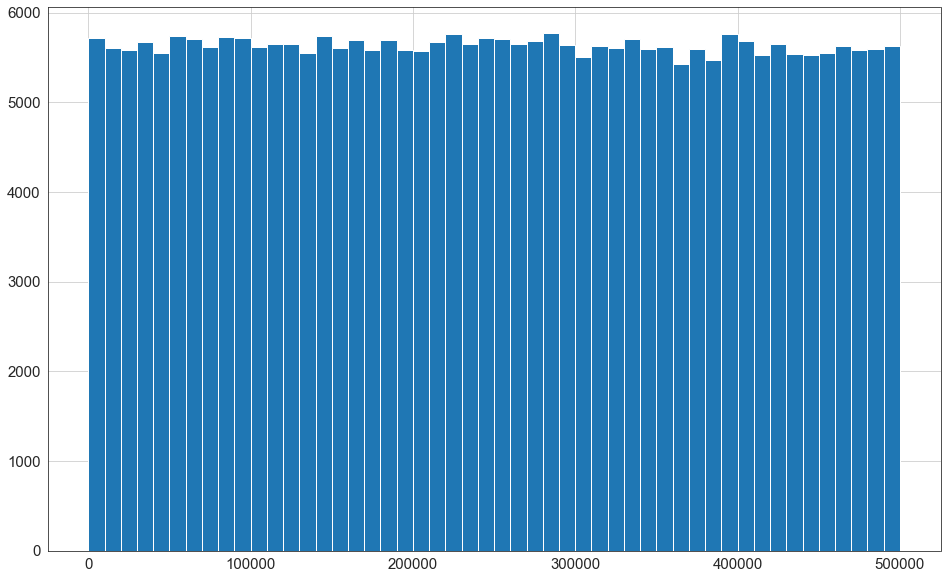

In [79]:
submission_df['gasto_familiar'].hist(bins=50)

<AxesSubplot:>

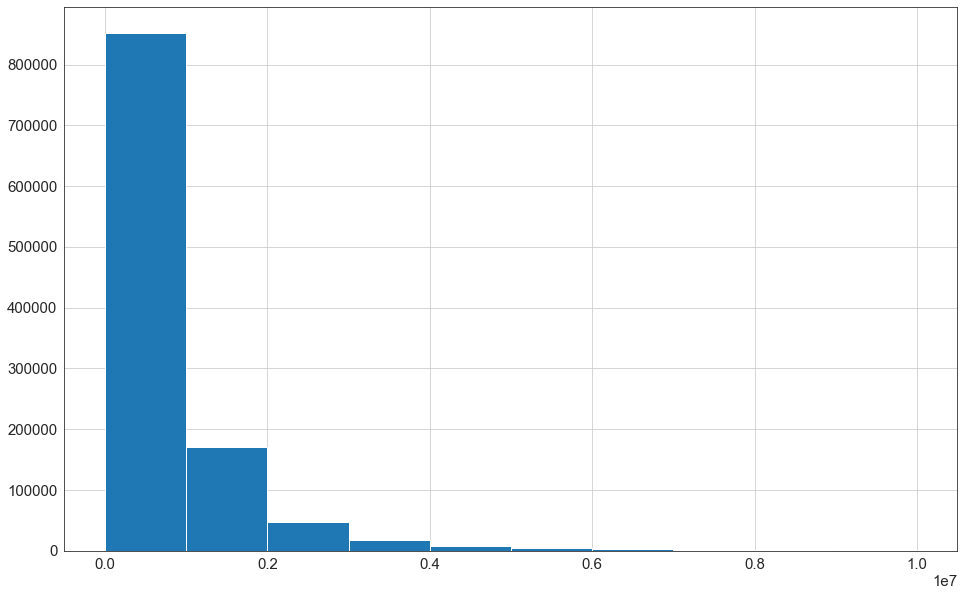

In [99]:
data_may[(data_may['gasto_familiar'] < 10000000) &
        (data_may['gasto_familiar'] >= 0)]['gasto_familiar'].hist()

In [83]:
data_may['gasto_familiar'].describe()

count    1.110830e+06
mean     8.246331e+05
std      1.944135e+06
min     -2.721883e+06
25%      1.965445e+05
50%      4.655459e+05
75%      9.456315e+05
max      3.542309e+08
Name: gasto_familiar, dtype: float64

In [98]:
len(data_may[(data_may['gasto_familiar'] < 10000000) &
        (data_may['gasto_familiar'] >= 0)]['gasto_familiar'])/len(data_may)

0.9968023910049243

In [3]:
test_dataframe=pd.read_csv("../data/dt2020_base_evaluar_corrected.csv")

In [5]:
cleaned_test_df = DataFrameBuilder(test_dataframe, test=True)

In [6]:
cleaned_test_df.build()

,id_registro,periodo,id_cli,edad,genero,estado_civil,ult_actual,ind_mora_vigente,departamento_residencia,mora_max,...,saldo_prom3_tdc_mdo,cuota_tc_mdo,saldo_no_rot_mdo,cuota_libranza_sf,cant_oblig_tot_sf,ind,rep_calif_cred,convenio_lib,ingreso_nomina,ingreso_segurida_social
0,4055#201902,201902,4055,46,M,CAS,20180807,N,ANTIOQUIA,NApl,...,2.825000e+05,19000.0,127148000.0,1797000.0,7,2.060457e+06,A,S,2734528.0,0.0
1,12598#201902,201902,12598,43,M,SOL,20180130,N,CUNDINAMARCA,Entre 0 y 30 dias,...,0.000000e+00,0.0,87661000.0,0.0,5,-7.187437e+07,H,S,2291070.0,0.0
2,23697#201902,201902,23697,45,M,CAS,20190110,N,BOGOTA D.C.,Entre 0 y 30 dias,...,3.300000e+04,33000.0,58967000.0,0.0,3,-1.448765e+06,A,S,0.0,0.0
3,23768#201902,201902,23768,58,M,NI,20180208,N,BOGOTA D.C.,NApl,...,0.000000e+00,0.0,0.0,0.0,0,2.208260e+06,G,S,0.0,0.0
4,7174#201902,201902,7174,52,F,DIV,20180825,N,BOGOTA D.C.,Entre 0 y 30 dias,...,4.088500e+06,11000.0,22746000.0,0.0,7,3.212636e+06,A,S,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281661,8596193#202011,202011,8596193,47,F,SOL,20201010,N,ANTIOQUIA,Entre 0 y 30 dias,...,0.000000e+00,0.0,0.0,0.0,2,2.101424e+06,A,S,2281362.5,3876343.0
281662,8616083#202011,202011,8616083,35,M,NI,20201003,N,BOGOTA D.C.,Entre 0 y 30 dias,...,8.286667e+06,237000.0,99000.0,0.0,12,1.170550e+07,C,S,14510896.0,0.0
281663,8670207#202011,202011,8670207,47,M,DIV,20200616,N,CUNDINAMARCA,Entre 0 y 30 dias,...,3.091700e+07,10350000.0,300000.0,0.0,17,-4.154790e+07,D,S,0.0,0.0
281664,8677655#202011,202011,8677655,42,F,CAS,20200423,N,ANTIOQUIA,Entre 0 y 30 dias,...,3.760867e+07,1953000.0,184811000.0,0.0,18,5.313457e+06,B,S,11401109.0,14481371.0


In [8]:
cleaned_test_df.cleaned_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 281666 entries, 0 to 281665
Data columns (total 39 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   id_registro                    281666 non-null  object 
 1   periodo                        281666 non-null  int64  
 2   id_cli                         281666 non-null  int64  
 3   edad                           281666 non-null  int32  
 4   genero                         281666 non-null  object 
 5   estado_civil                   281148 non-null  object 
 6   ult_actual                     281666 non-null  int64  
 7   ind_mora_vigente               281566 non-null  object 
 8   departamento_residencia        281554 non-null  object 
 9   mora_max                       281666 non-null  object 
 10  cupo_total_tc                  281666 non-null  float64
 11  cuota_tc_bancolombia           281666 non-null  float64
 12  nro_tot_cuentas               

In [2]:
np.exp(0) -1

NameError: name 'np' is not defined